# SECS example

This notebook has two parts:

  1. We specify a scalar field that represents the amplitudes of divergence-free spherical elementary currents (i.e., the curl of the current), and use this to calcualte the associated current field and ground magnetic field. This is the forward problem
  2. We extract magnetic field values for this current system at a limited set of points on the ground, and use these values to reconstruct the original scalar field. This is the the inverse problem.

*Note*: The purpose of this notebook is to demonstrate the use of the SECS "G matrices" (from `get_SECS_J_G_matrices` and `get_SECS_B_G_matrices`). We have to specify locations for the SECS poles and evaluation points. For this we use a `cubedsphere` grid, which is practial but by no means essential to SECS analysis. See other notebooks (also in the `lompe` module) for more detailed tutorials on using `cubedsphere`.

Also note that the units for the SECS poles (and hence the magnetic field an current) are completely arbitrary below, so we don't show them. 

## Part 1: Forward problem
In this example, the divergence-free SECS poles have amplitudes that form a picture of a racoon:

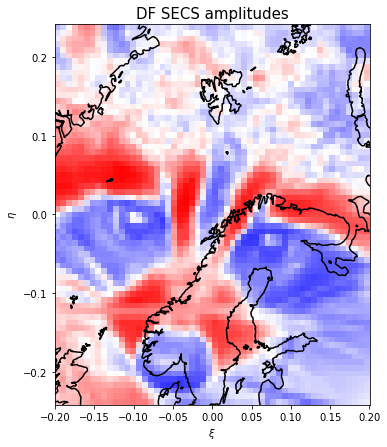

In [1]:
%matplotlib inline
from secsy import cubedsphere as cs
from secsy import CSplot
from secsy import get_SECS_J_G_matrices, get_SECS_B_G_matrices
import numpy as np
import pandas as pd
from scipy.misc import face
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# load racoon picture to represent the SECS divergence-free amplitude (the curl of the current)
I = gaussian_filter(face(gray = True), 3)[100:500:6, 500:-200:6][::-1] # smooth, crop, downsample, and turn upside-down
shp = I.shape
I = I - I.mean()

# set up cubed sphere projection and grid
projection = cs.CSprojection((15, 70), 0) # central (lon, lat) and orientation of the grid
grid = cs.CSgrid(projection, shp[1] * .5e5, shp[0]*.5e5, shp[0], shp[1], R = 6371.2e3, wshift = 1e3)

fig, ax = plt.subplots(figsize = (8, 7))
csax = CSplot(ax, grid, gridtype = 'cs')
csax.pcolormesh(grid.lon_mesh, grid.lat_mesh, I, cmap = plt.cm.bwr, vmin = -np.abs(I.max()), vmax = np.abs(I.max()))
csax.ax.set_title('DF SECS amplitudes', size = 15)
csax.add_coastlines(color = 'black', resolution = '50m')
plt.show()

Next we set up an evaluation grid. We use `grid.lon_mesh` and `grid.lat_mesh` because these points are optimally offset from `grid.lon` and `grid.lat`, so that we avoid any issue related to the singularity. This is important when evaluating the *current*, but not so important when evaluating the magnetic field on ground, since the singularity is strictly speaking only present at the current ionospheric current layer.

In [2]:
ss = slice(0, -1, 3) # downsample for vector plots
la, lo = grid.lat_mesh[ss, ss], grid.lon_mesh[ss, ss]

# matrices that calculate currents:
Gej, Gnj = get_SECS_J_G_matrices(la, lo, grid.lat, grid.lon) 
# and magnetic field on ground (evaluated on the full "mesh" grid, not downsampled):
GeB, GnB, GuB = get_SECS_B_G_matrices(grid.lat_mesh, grid.lon_mesh, 6371.2e3, grid.lat, grid.lon)

# Use matrices to calculate the actual values:
I = I.flatten()
je, jn = Gej.dot(I).reshape(la.shape), Gnj.dot(I).reshape(la.shape)
Be, Bn, Bu = GeB.dot(I).reshape(grid.lat_mesh.shape), GnB.dot(I).reshape(grid.lat_mesh.shape), GuB.dot(I).reshape(grid.lat_mesh.shape)



Next, plot the current vectors and ground magnetic field

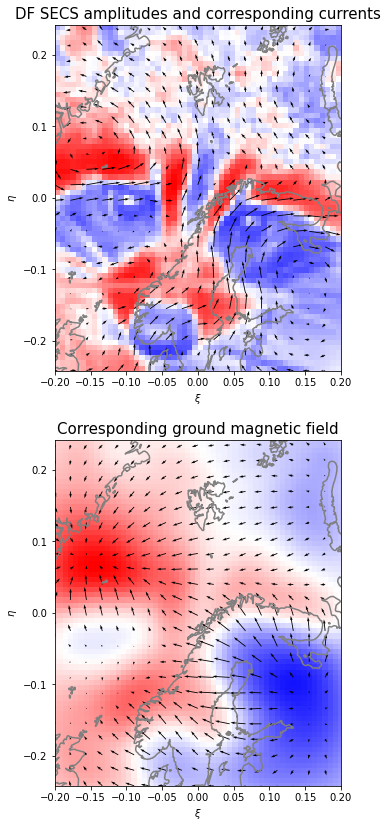

In [3]:
fig, axes = plt.subplots(nrows = 2, figsize = (8, 14))
csaxes = [CSplot(ax, grid, gridtype = 'cs') for ax in axes]

#x, y, Ax, Ay = projection.vector_cube_projection(je, jn, lo, la, return_xi_eta = True)
csaxes[0].pcolormesh(grid.lon_mesh, grid.lat_mesh, I.reshape(shp), cmap = plt.cm.bwr, vmin = -np.abs(I.max()), vmax = np.abs(I.max()))
csaxes[0].quiver(je, jn, lo, la)
csaxes[0].ax.set_title('DF SECS amplitudes and corresponding currents', size = 15)

csaxes[1].pcolormesh(grid.lon_mesh, grid.lat_mesh, Bu, cmap = plt.cm.bwr, vmin = -np.abs(Bu.max()), vmax = np.abs(Bu.max()))
csaxes[1].quiver(Be[ss, ss].flatten(), Bn[ss, ss].flatten(), lo, la)
csaxes[1].ax.set_title('Corresponding ground magnetic field', size = 15)

for a in csaxes:
    a.add_coastlines(color = 'grey', resolution = '50m')


plt.show()

## Part 2: Inverse problem: Retrieving the SECS poles
Below is an example of how measurements (in this case, synthetic measurements, based on the above synthetic current system) can be used to estimate the SECS poles. 

Start by producing synthetic measurements (basically sample the previously plotted map at `N` random location)

In [4]:
# find SuperMAG magnetometers that are in the grid:
stations = pd.read_csv('20230627-09-32-supermag-stations.csv', usecols = range(3))
iii = grid.ingrid(stations.GEOLON.values, stations.GEOLAT.values)
lon_mag, lat_mag = stations.GEOLON.values[iii], stations.GEOLAT.values[iii]
xi_mag, eta_mag = projection.geo2cube(lon_mag, lat_mag)

## # Alternatively, make random points:
## N = 20 # the number of ground magnetometers (will be placed at random points)
## 
## # make a set of random coordinates for the ground mags (using xi and eta to produce points):
## ximin  , etamin   = grid.xi.min(), grid.eta.min()
## xirange, etarange = grid.xi.max() - grid.xi.min(), grid.eta.max() - grid.eta.min()
## xi_mag, eta_mag = np.random.random(N) * xirange + ximin, np.random.random(N) * etarange + etamin
## lon_mag, lat_mag = projection.cube2geo(xi_mag, eta_mag)

# evaluate the magnetic field at these points:
GeB_mag, GnB_mag, GuB_mag = get_SECS_B_G_matrices(lat_mag, lon_mag, 6371.2e3, grid.lat, grid.lon)
Be_mag, Bn_mag, Bu_mag = GeB_mag.dot(I), GnB_mag.dot(I), GuB_mag.dot(I)

print('Synthetic dataset consists of {} magnetometers'.format(len(xi_mag)))

Synthetic dataset consists of 61 magnetometers


Now we solve the inverse problem. It is highly under-determined, so we have to regularize. We demonstrate two approaches:

  1. Truncated singular value decomposition, equivalent to zeroth order Tikhonov regularizion
  2. A mix between zeroth and first order Tikhonov regularization, damping gradients in the model parameter in the east-west direction. 
  
Both approaches correspond to a prior assumption about how the solution should behave: In (1) the assumption is that the solution is relatively smooth. (2) also includes an assumption that the solution has a particular structure. In real cases ionospheric electrodynamics tends to be organized as arcs in the magnetic east-west direction, so (2) often performs better than (1). In our example though, the solution looks like a racoon, so we should not expect to see this. Note that (2) is more complicated than (1) since it requires numerical differentiation to calcualte the gradient. Differentiation matrices are calculated in the `cubedsphere` module. 

(1) is computatinally cheap, while (2) can be rather heavy because of the need to calculate differentiation matrices and multiply matrices. However, if the geometry of the problem remains constant (same set of SECS poles, and same set of measurement stations), the heavy computations only have to be done once, and the matrices can be reused as the data is updated. 


In [5]:
# first we stack the G matrices and data vectors. These will be used in both approaches
G = np.vstack((GeB_mag, GnB_mag, GuB_mag)) # shape: (3*N, grid.size)
d = np.hstack((Be_mag, Bn_mag, Bu_mag))    # shape: (3*N)

# Approach number 1: Truncated singular value decomposition (TSVD)
truncation = 0.01 # truncate singular values below this fraction of the maximum
I_1 = np.linalg.lstsq(G, d, rcond = truncation)[0]

# Approach number 2: East-west minimization
De, Dn = grid.get_Le_Ln() # get matrices that calculate eastward and northward components of gradient
GTG, GTd = G.T.dot(G), G.T.dot(d) # we multiply the set of equations by G transpose
DTD = De.T.dot(De)
scale_gtg = np.median(GTG.diagonal()) # get typical magnitude of diagonal in order to give sensible damping parameters
scale_dtd = np.median(DTD.diagonal()) # typical magnitude of diagonal in diff matrix
T0, T1 = 1e-3 * scale_gtg, 1e-2 * scale_gtg/scale_dtd # damping parameters for zeroth and first order Tikhonov regularization
R = T0 * np.eye(grid.size) + T1 * DTD # regularization matrix
I_2 = np.linalg.lstsq(GTG + R, GTd, rcond = 0)[0]



plot the result, and mark the measurement locations by scatter points. For approach (1) the solution often appears patchy, while for approach (2), the solution often forms east-west aligned structures. In this case the `De` matrix refers to the eastward direction in geographic coordinates. If we wanted to minimize the gradient in the magnetic eastward diretion, `De` and `Dn` should be added together, weighted by the values of unit vectors that point in the magnetic eastward direction.

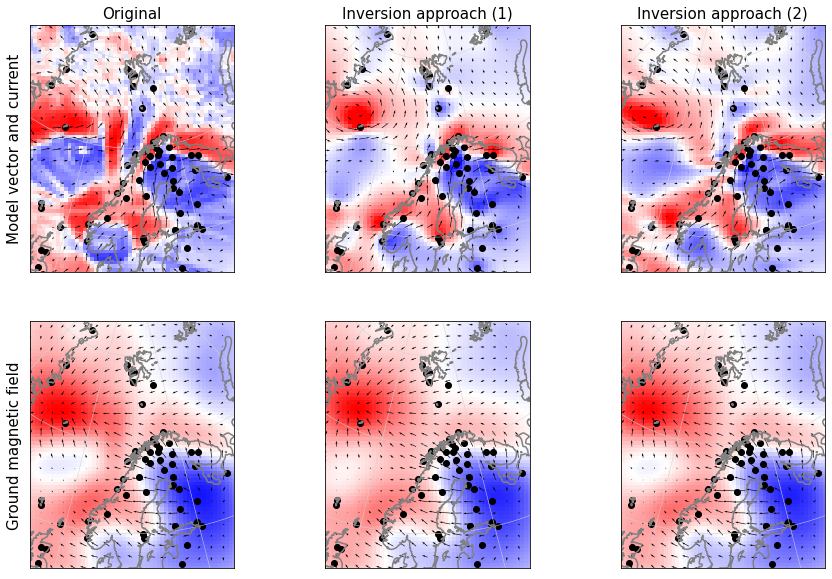

In [6]:
# Plot the original and the solutions
fig, axes = plt.subplots(ncols = 3, nrows = 2, figsize = (15, 10))
csaxes = [CSplot(ax, grid, gridtype = 'geo') for ax in axes.flatten()]

# plot the solution vector:
csaxes[0].pcolormesh(grid.lon_mesh, grid.lat_mesh, I.reshape(shp), cmap = plt.cm.bwr, vmin = -np.abs(I.max()), vmax = np.abs(I.max()))
csaxes[1].pcolormesh(grid.lon_mesh, grid.lat_mesh, I_1.reshape(shp), cmap = plt.cm.bwr, vmin = -np.abs(I.max()), vmax = np.abs(I.max()))
csaxes[2].pcolormesh(grid.lon_mesh, grid.lat_mesh, I_2.reshape(shp), cmap = plt.cm.bwr, vmin = -np.abs(I.max()), vmax = np.abs(I.max()))

# plot currents and magnetic fields
for i, model_vector in enumerate([I, I_1, I_2]):
    # current
    je, jn = Gej.dot(model_vector).reshape(la.shape), Gnj.dot(model_vector).reshape(la.shape)
    csaxes[i].quiver(je, jn, lo, la)

    # magnetic field
    Be, Bn, Bu = GeB.dot(model_vector).reshape(grid.lat_mesh.shape), GnB.dot(model_vector).reshape(grid.lat_mesh.shape), GuB.dot(model_vector).reshape(grid.lat_mesh.shape)
    csaxes[i + 3].quiver(Be[ss, ss].flatten(), Bn[ss, ss].flatten(), lo, la)
    csaxes[i + 3].pcolormesh(grid.lon_mesh, grid.lat_mesh, Bu, cmap = plt.cm.bwr, vmin = -np.abs(Bu.max()), vmax = np.abs(Bu.max()), zorder = 0)


csaxes[0].ax.set_title('Original', size = 15)
csaxes[1].ax.set_title('Inversion approach (1)', size = 15)
csaxes[2].ax.set_title('Inversion approach (2)', size = 15)
csaxes[0].ax.set_ylabel('Model vector and current', size = 15)
csaxes[3].ax.set_ylabel('Ground magnetic field', size = 15)



for a in csaxes:
    a.ax.scatter(xi_mag, eta_mag, c = 'black') 
    a.add_coastlines(color = 'grey', resolution = '50m')


plt.show()